In [2]:
from docai.annotations import AnnotationClient
from docai.generated.models import ModelTrainingDocumentStatus
from docai.annotations import normalize_ner_annotation_for_layoutlm
from datasets import Dataset
from datasets.features import ClassLabel
from docai.annotations import get_ner_tags_for_model
from transformers import AutoProcessor
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from docai.training import generate_layoutlm_compute_eval_metric_fn
from transformers import TrainingArguments, Trainer
from transformers import LayoutLMv3ForTokenClassification
from transformers.data.data_collator import default_data_collator
from transformers import AutoModelForTokenClassification
import torch
from PIL import ImageDraw, ImageFont

API_KEY = ""
MODEL_NAME = "bert-base-uncased-new"
MODEL_ID = ""

# Load annotations from Butler
butler_client = AnnotationClient(API_KEY)
annotations = butler_client.load_annotations(
    model_id=MODEL_ID,
    load_all_pages=True,
    document_status=ModelTrainingDocumentStatus.LABELED
)
print("Loaded {} annotations".format(len(annotations.training_documents)))



Loaded 90 annotations


In [3]:
import datasets


In [98]:
from docai.annotations import normalize_ner_annotation_for_layoutlm
from transformers import AutoTokenizer, BertForTokenClassification
from transformers import BertTokenizerFast
from transformers import TrainingArguments, Trainer
from torch.utils.data import Dataset
from datasets import ClassLabel, Features, Sequence, Value
from seqeval.metrics import classification_report
import torch
import datasets
from transformers import DataCollatorWithPadding, TrainingArguments, BertTokenizer, BertForSequenceClassification
from torch.nn.utils.rnn import pad_sequence


annotations_as_ner = annotations.as_ner(as_iob2=True)
#annotations_as_ner = list(map(normalize_ner_annotation_for_layoutlm, annotations_as_ner))

# Create dataset
dataset = datasets.Dataset.from_list(annotations_as_ner)

# Get model NER tags and label mapping
model_ner_tags = get_ner_tags_for_model(annotations.model_details)
label_list = model_ner_tags["tags"]
class_label = ClassLabel(names=label_list)
id2label = {k: v for k, v in enumerate(label_list)}
label2id = {v: k for k, v in enumerate(label_list)}
column_names = dataset.column_names

In [99]:


# Split dataset into train/test
dataset = dataset.train_test_split(test_size=0.2, shuffle=True)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define features
features = Features({
    'input_ids': Sequence(Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'labels': Sequence(Value(dtype='int64')),
})

def convert_ner_tags_to_id(ner_tags):
    return [label2id[ner_tag] for ner_tag in ner_tags]

def prepare_dataset(examples):
    max_token_length = max(len(tokens) for tokens in examples['tokens'])

    input_encodings = tokenizer(
        examples['tokens'],
        truncation=True,
        padding='max_length',
        max_length=max_token_length,
        is_split_into_words=True
    )

    labels = [convert_ner_tags_to_id(tags) for tags in examples['ner_tags']]
    label_encodings = pad_sequence(
        [torch.tensor(label) for label in labels],
        batch_first=True,
        padding_value=label2id['O']
    )

    # Pad the input encodings
    input_ids = pad_sequence(
        [torch.tensor(ids) for ids in input_encodings['input_ids']],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )
    attention_mask = pad_sequence(
        [torch.tensor(mask) for mask in input_encodings['attention_mask']],
        batch_first=True,
        padding_value=0  # Attention mask should be 0 for padding tokens
    )

    # Pad the label encodings
    label_encodings = pad_sequence(
        [torch.tensor(label) for label in labels],
        batch_first=True,
        padding_value=label2id['O']
    )

    # Create a custom BatchEncoding object
    batch_encoding = {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': label_encodings,
    }

    return batch_encoding




# Split dataset into train/test
train_size = int(len(dataset["train"]) * 0.5)
train_dataset = dataset["train"][:train_size]
test_dataset = dataset["train"][train_size:]

# Print the lengths of the train and test datasets
print("Train dataset length:", len(train_dataset))
print("Test dataset length:", len(test_dataset))
train_dataset = datasets.Dataset.from_dict(train_dataset)
test_dataset = datasets.Dataset.from_dict(test_dataset)
print("Train dataset length:", len(train_dataset))
print("Test dataset length:", len(test_dataset))
# Prepare train and eval
train_dataset = train_dataset.map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)

eval_dataset = test_dataset.map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)


from seqeval.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_eval_metrics(pred):
    # Flatten the predicted and true labels
    pred_flat = pred.predictions.argmax(-1).flatten().tolist()
    labels_flat = pred.label_ids.flatten().tolist()

    # Convert label IDs to label names
    pred_labels = [id2label[label_id] for label_id in pred_flat]
    true_labels = [id2label[label_id] for label_id in labels_flat]

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, pred_labels)

    # Calculate precision, recall, and F1 score per class
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average=None)

    # Create a dictionary to store the metrics per class
    class_metrics = {}
    for label, prec, rec, f in zip(label_list, precision, recall, f1):
        class_metrics[label] = {
            'precision': prec,
            'recall': rec,
            'f1': f
        }

    return {
        'accuracy': accuracy,
        'class_metrics': class_metrics
    }


# Load BERT-based model for token classification
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="/Users/giuliamenichini/Downloads/lavoro/bert-base-uncased_last1",
    max_steps=1000,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    learning_rate=2e-5,
    evaluation_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

transformers_data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_eval_metrics
)







Train dataset length: 5
Test dataset length: 5
Train dataset length: 36
Test dataset length: 36


Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: 

In [100]:
trainer.train()


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: giuliamenichini97 (proof1234). Use `wandb login --relogin` to force relogin


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'O': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-Date': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-code': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-text': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Date': {'precision': 0.42727272727272725, 'recall': 0.7704918032786885, 'f1': 0.5497076023391813}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.8553987027851965, 'recall': 0.944795617361989, 'f1': 0.8978774529435323}, 'I-text': {'precision': 0.9848972035467213, 'recall': 0.9731395012997015, 'f1': 0.9789

{'eval_loss': 0.16459672152996063, 'eval_accuracy': 0.9496336996336996, 'eval_class_metrics': {'O': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-Date': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-code': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-text': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Date': {'precision': 0.42727272727272725, 'recall': 0.7704918032786885, 'f1': 0.5497076023391813}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.8553987027851965, 'recall': 0.944795617361989, 'f1': 0.8978774529435323}, 'I-text': {'precision': 0.9848972035467213, 'recall': 0.9731395012997015, 'f1': 0.9789830508474576}}, 'eval_runtime': 6.2687, 'eval_samples_per_second': 5.743, 'eval_steps_per_second': 5.743, 'epoch': 2.78}


  0%|          | 0/36 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'O': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-Date': {'precision': 1.0, 'recall': 0.9722222222222222, 'f1': 0.9859154929577464}, 'B-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-code': {'precision': 0.6666666666666666, 'recall': 0.05555555555555555, 'f1': 0.10256410256410256}, 'B-text': {'precision': 0.45098039215686275, 'recall': 0.3484848484848485, 'f1': 0.39316239316239315}, 'I-Date': {'precision': 0.5555555555555556, 'recall': 0.9426229508196722, 'f1': 0.6990881458966566}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.8963688290493677, 'recall': 0.9258322

{'eval_loss': 0.1657312512397766, 'eval_accuracy': 0.9581043956043956, 'eval_class_metrics': {'O': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-Date': {'precision': 1.0, 'recall': 0.9722222222222222, 'f1': 0.9859154929577464}, 'B-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-code': {'precision': 0.6666666666666666, 'recall': 0.05555555555555555, 'f1': 0.10256410256410256}, 'B-text': {'precision': 0.45098039215686275, 'recall': 0.3484848484848485, 'f1': 0.39316239316239315}, 'I-Date': {'precision': 0.5555555555555556, 'recall': 0.9426229508196722, 'f1': 0.6990881458966566}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.8963688290493677, 'recall': 0.9258322798145807, 'f1': 0.9108623548922057}, 'I-text': {'precision': 0.9831997682726659, 'recall': 0.9803600654664485, 'f1': 0.9817778634785963}}, 'eval_runtime': 6.6445, 'eval_samples_per_second': 5.418, 'eval_steps_per_second': 5.418, 'epoch': 5.56}


  0%|          | 0/36 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'O': {'precision': 0.5454545454545454, 'recall': 0.16666666666666666, 'f1': 0.2553191489361702}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-code': {'precision': 0.1875, 'recall': 0.16666666666666666, 'f1': 0.17647058823529413}, 'B-text': {'precision': 0.34146341463414637, 'recall': 0.6363636363636364, 'f1': 0.4444444444444445}, 'I-Date': {'precision': 0.6626506024096386, 'recall': 0.9016393442622951, 'f1': 0.7638888888888888}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.9093579521611415, 'recall': 0.9131

{'eval_loss': 0.1605546623468399, 'eval_accuracy': 0.9590964590964591, 'eval_class_metrics': {'O': {'precision': 0.5454545454545454, 'recall': 0.16666666666666666, 'f1': 0.2553191489361702}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-code': {'precision': 0.1875, 'recall': 0.16666666666666666, 'f1': 0.17647058823529413}, 'B-text': {'precision': 0.34146341463414637, 'recall': 0.6363636363636364, 'f1': 0.4444444444444445}, 'I-Date': {'precision': 0.6626506024096386, 'recall': 0.9016393442622951, 'f1': 0.7638888888888888}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.9093579521611415, 'recall': 0.9131900547829751, 'f1': 0.9112699747687131}, 'I-text': {'precision': 0.9854134466769706, 'recall': 0.9820930008664677, 'f1': 0.9837504219104103}}, 'eval_runtime': 6.7852, 'eval_samples_per_second': 5.306, 'eval_steps_per_second': 5.306, 'epoch': 8.33}


  0%|          | 0/36 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'O': {'precision': 0.48717948717948717, 'recall': 0.5277777777777778, 'f1': 0.5066666666666667}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-code': {'precision': 0.32, 'recall': 0.2222222222222222, 'f1': 0.26229508196721313}, 'B-text': {'precision': 0.42574257425742573, 'recall': 0.6515151515151515, 'f1': 0.5149700598802396}, 'I-Date': {'precision': 0.8467741935483871, 'recall': 0.860655737704918, 'f1': 0.853658536585366}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.9210641081552551, 'recall': 0.890012642

{'eval_loss': 0.1764557808637619, 'eval_accuracy': 0.9576465201465202, 'eval_class_metrics': {'O': {'precision': 0.48717948717948717, 'recall': 0.5277777777777778, 'f1': 0.5066666666666667}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-code': {'precision': 0.32, 'recall': 0.2222222222222222, 'f1': 0.26229508196721313}, 'B-text': {'precision': 0.42574257425742573, 'recall': 0.6515151515151515, 'f1': 0.5149700598802396}, 'I-Date': {'precision': 0.8467741935483871, 'recall': 0.860655737704918, 'f1': 0.853658536585366}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.9210641081552551, 'recall': 0.8900126422250316, 'f1': 0.9052721817402486}, 'I-text': {'precision': 0.9764155447340781, 'recall': 0.9844998555887167, 'f1': 0.9804410354745924}}, 'eval_runtime': 6.6569, 'eval_samples_per_second': 5.408, 'eval_steps_per_second': 5.408, 'epoch': 11.11}
{'loss': 0.1203, 'learning_rate': 1e-05, 'e

  0%|          | 0/36 [00:00<?, ?it/s]

Trainer is attempting to log a value of "{'O': {'precision': 0.48, 'recall': 0.6666666666666666, 'f1': 0.5581395348837209}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.047619047619047616, 'recall': 0.05555555555555555, 'f1': 0.05128205128205128}, 'B-code': {'precision': 0.19047619047619047, 'recall': 0.2222222222222222, 'f1': 0.20512820512820512}, 'B-text': {'precision': 0.375, 'recall': 0.5454545454545454, 'f1': 0.4444444444444444}, 'I-Date': {'precision': 0.8852459016393442, 'recall': 0.8852459016393442, 'f1': 0.8852459016393442}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.916383701188455, 'recall': 0.909818794774547, 'f1': 0.9130894480862761}, 'I-text': {'precision': 0.985110702890844, 'recall': 0.9809377105997882, 'f1': 0.9830197780993729}}" of type <class 'dict'> for key "eval/class_metrics" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.18275399506092072, 'eval_accuracy': 0.9586385836385837, 'eval_class_metrics': {'O': {'precision': 0.48, 'recall': 0.6666666666666666, 'f1': 0.5581395348837209}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.047619047619047616, 'recall': 0.05555555555555555, 'f1': 0.05128205128205128}, 'B-code': {'precision': 0.19047619047619047, 'recall': 0.2222222222222222, 'f1': 0.20512820512820512}, 'B-text': {'precision': 0.375, 'recall': 0.5454545454545454, 'f1': 0.4444444444444444}, 'I-Date': {'precision': 0.8852459016393442, 'recall': 0.8852459016393442, 'f1': 0.8852459016393442}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.916383701188455, 'recall': 0.909818794774547, 'f1': 0.9130894480862761}, 'I-text': {'precision': 0.985110702890844, 'recall': 0.9809377105997882, 'f1': 0.9830197780993729}}, 'eval_runtime': 6.9362, 'eval_samples_per_second': 5.19, 'eval_steps_per_second': 5.19, 'epoch': 13.89}


  0%|          | 0/36 [00:00<?, ?it/s]

Trainer is attempting to log a value of "{'O': {'precision': 0.48148148148148145, 'recall': 0.7222222222222222, 'f1': 0.5777777777777777}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.06349206349206349, 'recall': 0.1111111111111111, 'f1': 0.08080808080808081}, 'B-code': {'precision': 0.2777777777777778, 'recall': 0.2777777777777778, 'f1': 0.2777777777777778}, 'B-text': {'precision': 0.4567901234567901, 'recall': 0.5606060606060606, 'f1': 0.5034013605442176}, 'I-Date': {'precision': 0.9008264462809917, 'recall': 0.8934426229508197, 'f1': 0.897119341563786}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.91921768707483, 'recall': 0.9110830172777076, 'f1': 0.9151322751322752}, 'I-text': {'precision': 0.9844459472514733, 'recall': 0.9810339847886782, 'f1': 0.9827370045327419}}" of type <class 'dict'> for key "eval/class_metrics" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we droppe

{'eval_loss': 0.18327148258686066, 'eval_accuracy': 0.9595543345543346, 'eval_class_metrics': {'O': {'precision': 0.48148148148148145, 'recall': 0.7222222222222222, 'f1': 0.5777777777777777}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.06349206349206349, 'recall': 0.1111111111111111, 'f1': 0.08080808080808081}, 'B-code': {'precision': 0.2777777777777778, 'recall': 0.2777777777777778, 'f1': 0.2777777777777778}, 'B-text': {'precision': 0.4567901234567901, 'recall': 0.5606060606060606, 'f1': 0.5034013605442176}, 'I-Date': {'precision': 0.9008264462809917, 'recall': 0.8934426229508197, 'f1': 0.897119341563786}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.91921768707483, 'recall': 0.9110830172777076, 'f1': 0.9151322751322752}, 'I-text': {'precision': 0.9844459472514733, 'recall': 0.9810339847886782, 'f1': 0.9827370045327419}}, 'eval_runtime': 6.7704, 'eval_samples_per_second': 5.317, 'eval_steps_per_second': 5.317, 

  0%|          | 0/36 [00:00<?, ?it/s]

Trainer is attempting to log a value of "{'O': {'precision': 0.46296296296296297, 'recall': 0.6944444444444444, 'f1': 0.5555555555555555}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.061224489795918366, 'recall': 0.08333333333333333, 'f1': 0.07058823529411765}, 'B-code': {'precision': 0.21818181818181817, 'recall': 0.3333333333333333, 'f1': 0.26373626373626374}, 'B-text': {'precision': 0.43333333333333335, 'recall': 0.5909090909090909, 'f1': 0.5}, 'I-Date': {'precision': 0.9532710280373832, 'recall': 0.8360655737704918, 'f1': 0.890829694323144}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.9174154899443732, 'recall': 0.9034976822587442, 'f1': 0.9104033970276009}, 'I-text': {'precision': 0.9841453982985305, 'recall': 0.9800712428997785, 'f1': 0.9821040953161931}}" of type <class 'dict'> for key "eval/class_metrics" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 0.20438234508037567, 'eval_accuracy': 0.9570360195360196, 'eval_class_metrics': {'O': {'precision': 0.46296296296296297, 'recall': 0.6944444444444444, 'f1': 0.5555555555555555}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.061224489795918366, 'recall': 0.08333333333333333, 'f1': 0.07058823529411765}, 'B-code': {'precision': 0.21818181818181817, 'recall': 0.3333333333333333, 'f1': 0.26373626373626374}, 'B-text': {'precision': 0.43333333333333335, 'recall': 0.5909090909090909, 'f1': 0.5}, 'I-Date': {'precision': 0.9532710280373832, 'recall': 0.8360655737704918, 'f1': 0.890829694323144}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.9174154899443732, 'recall': 0.9034976822587442, 'f1': 0.9104033970276009}, 'I-text': {'precision': 0.9841453982985305, 'recall': 0.9800712428997785, 'f1': 0.9821040953161931}}, 'eval_runtime': 6.8676, 'eval_samples_per_second': 5.242, 'eval_steps_per_second': 5.242, 'epoch':

  0%|          | 0/36 [00:00<?, ?it/s]

Trainer is attempting to log a value of "{'O': {'precision': 0.45454545454545453, 'recall': 0.6944444444444444, 'f1': 0.5494505494505494}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.06557377049180328, 'recall': 0.1111111111111111, 'f1': 0.08247422680412371}, 'B-code': {'precision': 0.2708333333333333, 'recall': 0.3611111111111111, 'f1': 0.3095238095238095}, 'B-text': {'precision': 0.4482758620689655, 'recall': 0.5909090909090909, 'f1': 0.5098039215686274}, 'I-Date': {'precision': 0.9363636363636364, 'recall': 0.8442622950819673, 'f1': 0.8879310344827586}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.9228130360205832, 'recall': 0.9068689422671724, 'f1': 0.9147715196599363}, 'I-text': {'precision': 0.9847269212179797, 'recall': 0.9807451622220082, 'f1': 0.9827320084892919}}" of type <class 'dict'> for key "eval/class_metrics" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dro

{'eval_loss': 0.20494844019412994, 'eval_accuracy': 0.958409645909646, 'eval_class_metrics': {'O': {'precision': 0.45454545454545453, 'recall': 0.6944444444444444, 'f1': 0.5494505494505494}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.06557377049180328, 'recall': 0.1111111111111111, 'f1': 0.08247422680412371}, 'B-code': {'precision': 0.2708333333333333, 'recall': 0.3611111111111111, 'f1': 0.3095238095238095}, 'B-text': {'precision': 0.4482758620689655, 'recall': 0.5909090909090909, 'f1': 0.5098039215686274}, 'I-Date': {'precision': 0.9363636363636364, 'recall': 0.8442622950819673, 'f1': 0.8879310344827586}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.9228130360205832, 'recall': 0.9068689422671724, 'f1': 0.9147715196599363}, 'I-text': {'precision': 0.9847269212179797, 'recall': 0.9807451622220082, 'f1': 0.9827320084892919}}, 'eval_runtime': 6.8208, 'eval_samples_per_second': 5.278, 'eval_steps_per_second': 5.278

  0%|          | 0/36 [00:00<?, ?it/s]

Trainer is attempting to log a value of "{'O': {'precision': 0.46, 'recall': 0.6388888888888888, 'f1': 0.5348837209302325}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.05555555555555555, 'recall': 0.1111111111111111, 'f1': 0.07407407407407407}, 'B-code': {'precision': 0.2826086956521739, 'recall': 0.3611111111111111, 'f1': 0.3170731707317073}, 'B-text': {'precision': 0.4588235294117647, 'recall': 0.5909090909090909, 'f1': 0.5165562913907285}, 'I-Date': {'precision': 0.9137931034482759, 'recall': 0.8688524590163934, 'f1': 0.8907563025210085}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.9215017064846417, 'recall': 0.9102402022756005, 'f1': 0.9158363366546535}, 'I-text': {'precision': 0.9862363090045556, 'recall': 0.9795898719553288, 'f1': 0.982901854714065}}" of type <class 'dict'> for key "eval/class_metrics" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attrib

{'eval_loss': 0.20716817677021027, 'eval_accuracy': 0.9581807081807082, 'eval_class_metrics': {'O': {'precision': 0.46, 'recall': 0.6388888888888888, 'f1': 0.5348837209302325}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.05555555555555555, 'recall': 0.1111111111111111, 'f1': 0.07407407407407407}, 'B-code': {'precision': 0.2826086956521739, 'recall': 0.3611111111111111, 'f1': 0.3170731707317073}, 'B-text': {'precision': 0.4588235294117647, 'recall': 0.5909090909090909, 'f1': 0.5165562913907285}, 'I-Date': {'precision': 0.9137931034482759, 'recall': 0.8688524590163934, 'f1': 0.8907563025210085}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.9215017064846417, 'recall': 0.9102402022756005, 'f1': 0.9158363366546535}, 'I-text': {'precision': 0.9862363090045556, 'recall': 0.9795898719553288, 'f1': 0.982901854714065}}, 'eval_runtime': 6.9173, 'eval_samples_per_second': 5.204, 'eval_steps_per_second': 5.204, 'epoch': 25.0

  0%|          | 0/36 [00:00<?, ?it/s]

Trainer is attempting to log a value of "{'O': {'precision': 0.4423076923076923, 'recall': 0.6388888888888888, 'f1': 0.5227272727272726}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.04878048780487805, 'recall': 0.1111111111111111, 'f1': 0.06779661016949154}, 'B-code': {'precision': 0.29545454545454547, 'recall': 0.3611111111111111, 'f1': 0.325}, 'B-text': {'precision': 0.4588235294117647, 'recall': 0.5909090909090909, 'f1': 0.5165562913907285}, 'I-Date': {'precision': 0.9122807017543859, 'recall': 0.8524590163934426, 'f1': 0.8813559322033898}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.9225171232876712, 'recall': 0.9081331647703329, 'f1': 0.9152686345296241}, 'I-text': {'precision': 0.986333236405932, 'recall': 0.9796861461442188, 'f1': 0.9829984544049458}}" of type <class 'dict'> for key "eval/class_metrics" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attr

{'eval_loss': 0.2086373269557953, 'eval_accuracy': 0.9577228327228328, 'eval_class_metrics': {'O': {'precision': 0.4423076923076923, 'recall': 0.6388888888888888, 'f1': 0.5227272727272726}, 'B-Date': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-Dear': {'precision': 0.04878048780487805, 'recall': 0.1111111111111111, 'f1': 0.06779661016949154}, 'B-code': {'precision': 0.29545454545454547, 'recall': 0.3611111111111111, 'f1': 0.325}, 'B-text': {'precision': 0.4588235294117647, 'recall': 0.5909090909090909, 'f1': 0.5165562913907285}, 'I-Date': {'precision': 0.9122807017543859, 'recall': 0.8524590163934426, 'f1': 0.8813559322033898}, 'I-Dear': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-code': {'precision': 0.9225171232876712, 'recall': 0.9081331647703329, 'f1': 0.9152686345296241}, 'I-text': {'precision': 0.986333236405932, 'recall': 0.9796861461442188, 'f1': 0.9829984544049458}}, 'eval_runtime': 6.7565, 'eval_samples_per_second': 5.328, 'eval_steps_per_second': 5.328, 'epoch': 27.

TrainOutput(global_step=1000, training_loss=0.06441950559616089, metrics={'train_runtime': 751.7583, 'train_samples_per_second': 1.33, 'train_steps_per_second': 1.33, 'train_loss': 0.06441950559616089, 'epoch': 27.78})

In [129]:
from transformers import BertTokenizer, BertForTokenClassification
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForTokenClassification.from_pretrained("/Users/giuliamenichini/Downloads/lavoro/bert-base-uncased_last1/checkpoint-1000")

example = dataset["test"][2]
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
ner_tags = convert_ner_tags_to_id(example["ner_tags"])

input_ids = []
attention_mask = []
token_type_ids = []

for word in words:
    tokens = tokenizer.tokenize(word)
    encoded_input = tokenizer.encode_plus(tokens, add_special_tokens=False, truncation=True, max_length=512)
    input_ids.extend(encoded_input['input_ids'])
    attention_mask.extend(encoded_input['attention_mask'])
    token_type_ids.extend([0] * len(tokens))

input_ids = torch.tensor(input_ids).unsqueeze(0)
attention_mask = torch.tensor(attention_mask).unsqueeze(0)
token_type_ids = torch.tensor(token_type_ids).unsqueeze(0)

if torch.cuda.is_available():
    input_ids = input_ids.to("cuda")
    attention_mask = attention_mask.to("cuda")
    token_type_ids = token_type_ids.to("cuda")
    model.to("cuda")

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

logits = outputs.logits
predictions = logits.argmax(-1).squeeze().tolist()

def unnormalize_box(bbox, width, height):
    return [
    width * (bbox[0] / 1000) ,
    height * (bbox[1] / 1000) ,
    width * (bbox[2] / 1000) ,
    height * (bbox[3] / 1000) ,
    ]

token_boxes = torch.tensor(boxes).unsqueeze(0)  # Convert `boxes` to a tensor and unsqueeze
token_boxes = token_boxes.squeeze().tolist()
width, height = image.size
predictions = trainer.predict(eval_dataset)

# Retrieve predicted labels and true labels
predicted_labels = [[id2label[label_id] for label_id in labels] for labels in predictions.predictions.argmax(axis=2)]
true_labels = [[id2label[label_id] for label_id in labels] for labels in eval_dataset['labels']]

# Print predictions and ground truth for each tokenized sentence

print("Text:", " ".join(example['tokens']))
for i in range(len(predicted_labels)):

  print("Predicted labels:", " ".join(predicted_labels[i]))
  print("True labels:", " ".join(example['ner_tags']))
  print()
true_labels = ner_tags

true_boxes = [unnormalize_box(box, width, height) for box in token_boxes]


  0%|          | 0/36 [00:00<?, ?it/s]

Text: Dear Mr. Austern: March 10, 1982 As requested, I have examined the date records consisting of labora- tory determination calculation sheets and statistical summary sheets which you represented to me to be copies of the original laboratory data sheets compiled by the Federal Trade Commission and used as the basis for figures on "tar" TPM (Dry) and nicotine yields of various brands of cigarettes as well as the final reports on these data released by the Federal Trade Com- mission. It was the laboratory data sheets for the "tar" and nicotine figures released by the Federal Trade Commission under the date December 1981 which I examined and upon which I report in this letter. TITL00-03493 THE BERNARD M. BARUCH COLLEGE OF THE CITY UNIVERSITY OF NEW YORK 17 LEXINGTON AVENUE . NEW YORK, N. Y. 10010 533-7480 HERBERT ARKIN Professor Emeritus Mr. H. Thomas Austern Covington & Burling 1201 Pennsylvania Avenue N.W. P.O. Box 7566 Washington, D.C. 20044
Predicted labels: B-Dear I-Dear I-Dear I-

In [130]:
def iob_to_label(tag):
    if tag == 'B-Date' or tag == 'B-code' or tag == 'B-text' or tag == 'B-Dear':
        return tag[2:]
    elif  tag == 'I-Date' or tag == 'I-code' or tag == 'I-text' or tag == 'I-Dear':

        return tag[2:]
    else:
        return 'other'

def draw_boxes_on_img(preds_or_labels, boxes, draw, image, unnormalize=False):
    label_color_lookup = {
        "dear": "green",
        "date": "blue",
        "text": "red",
        "code": "purple"
    }

    font_path = "/content/drive/MyDrive/Arial Unicode.ttf"  # Replace with the actual path to your font file
    font_size = 12
    font = ImageFont.truetype(font_path, font_size)

    if unnormalize:
        width, height = image.size
        for pred_or_label, box in zip(preds_or_labels, boxes):
            label = iob_to_label(pred_or_label).lower()

            if label == 'other':
                continue

            x1, y1, x2, y2 = box
            x1_pixel = int(x1 * width )
            y1_pixel = int(y1 * height )
            x2_pixel = int(x2 * width )
            y2_pixel = int(y2 * height )

            color = label_color_lookup.get(label, "gray")
            draw.rectangle([(x1_pixel, y1_pixel), (x2_pixel, y2_pixel)], outline=color)
            draw.text((x1_pixel + 10, y1_pixel - 10), text=label, fill=color, font=font)
    else:
        for pred_or_label, box in zip(preds_or_labels, boxes):
            label = iob_to_label(pred_or_label).lower()

            if label == 'other':
                continue

            color = label_color_lookup.get(label, "gray")
            draw.rectangle(box, outline=color)
            draw.text((box[0] + 10, box[1] - 10), text=label, fill=color, font=font)


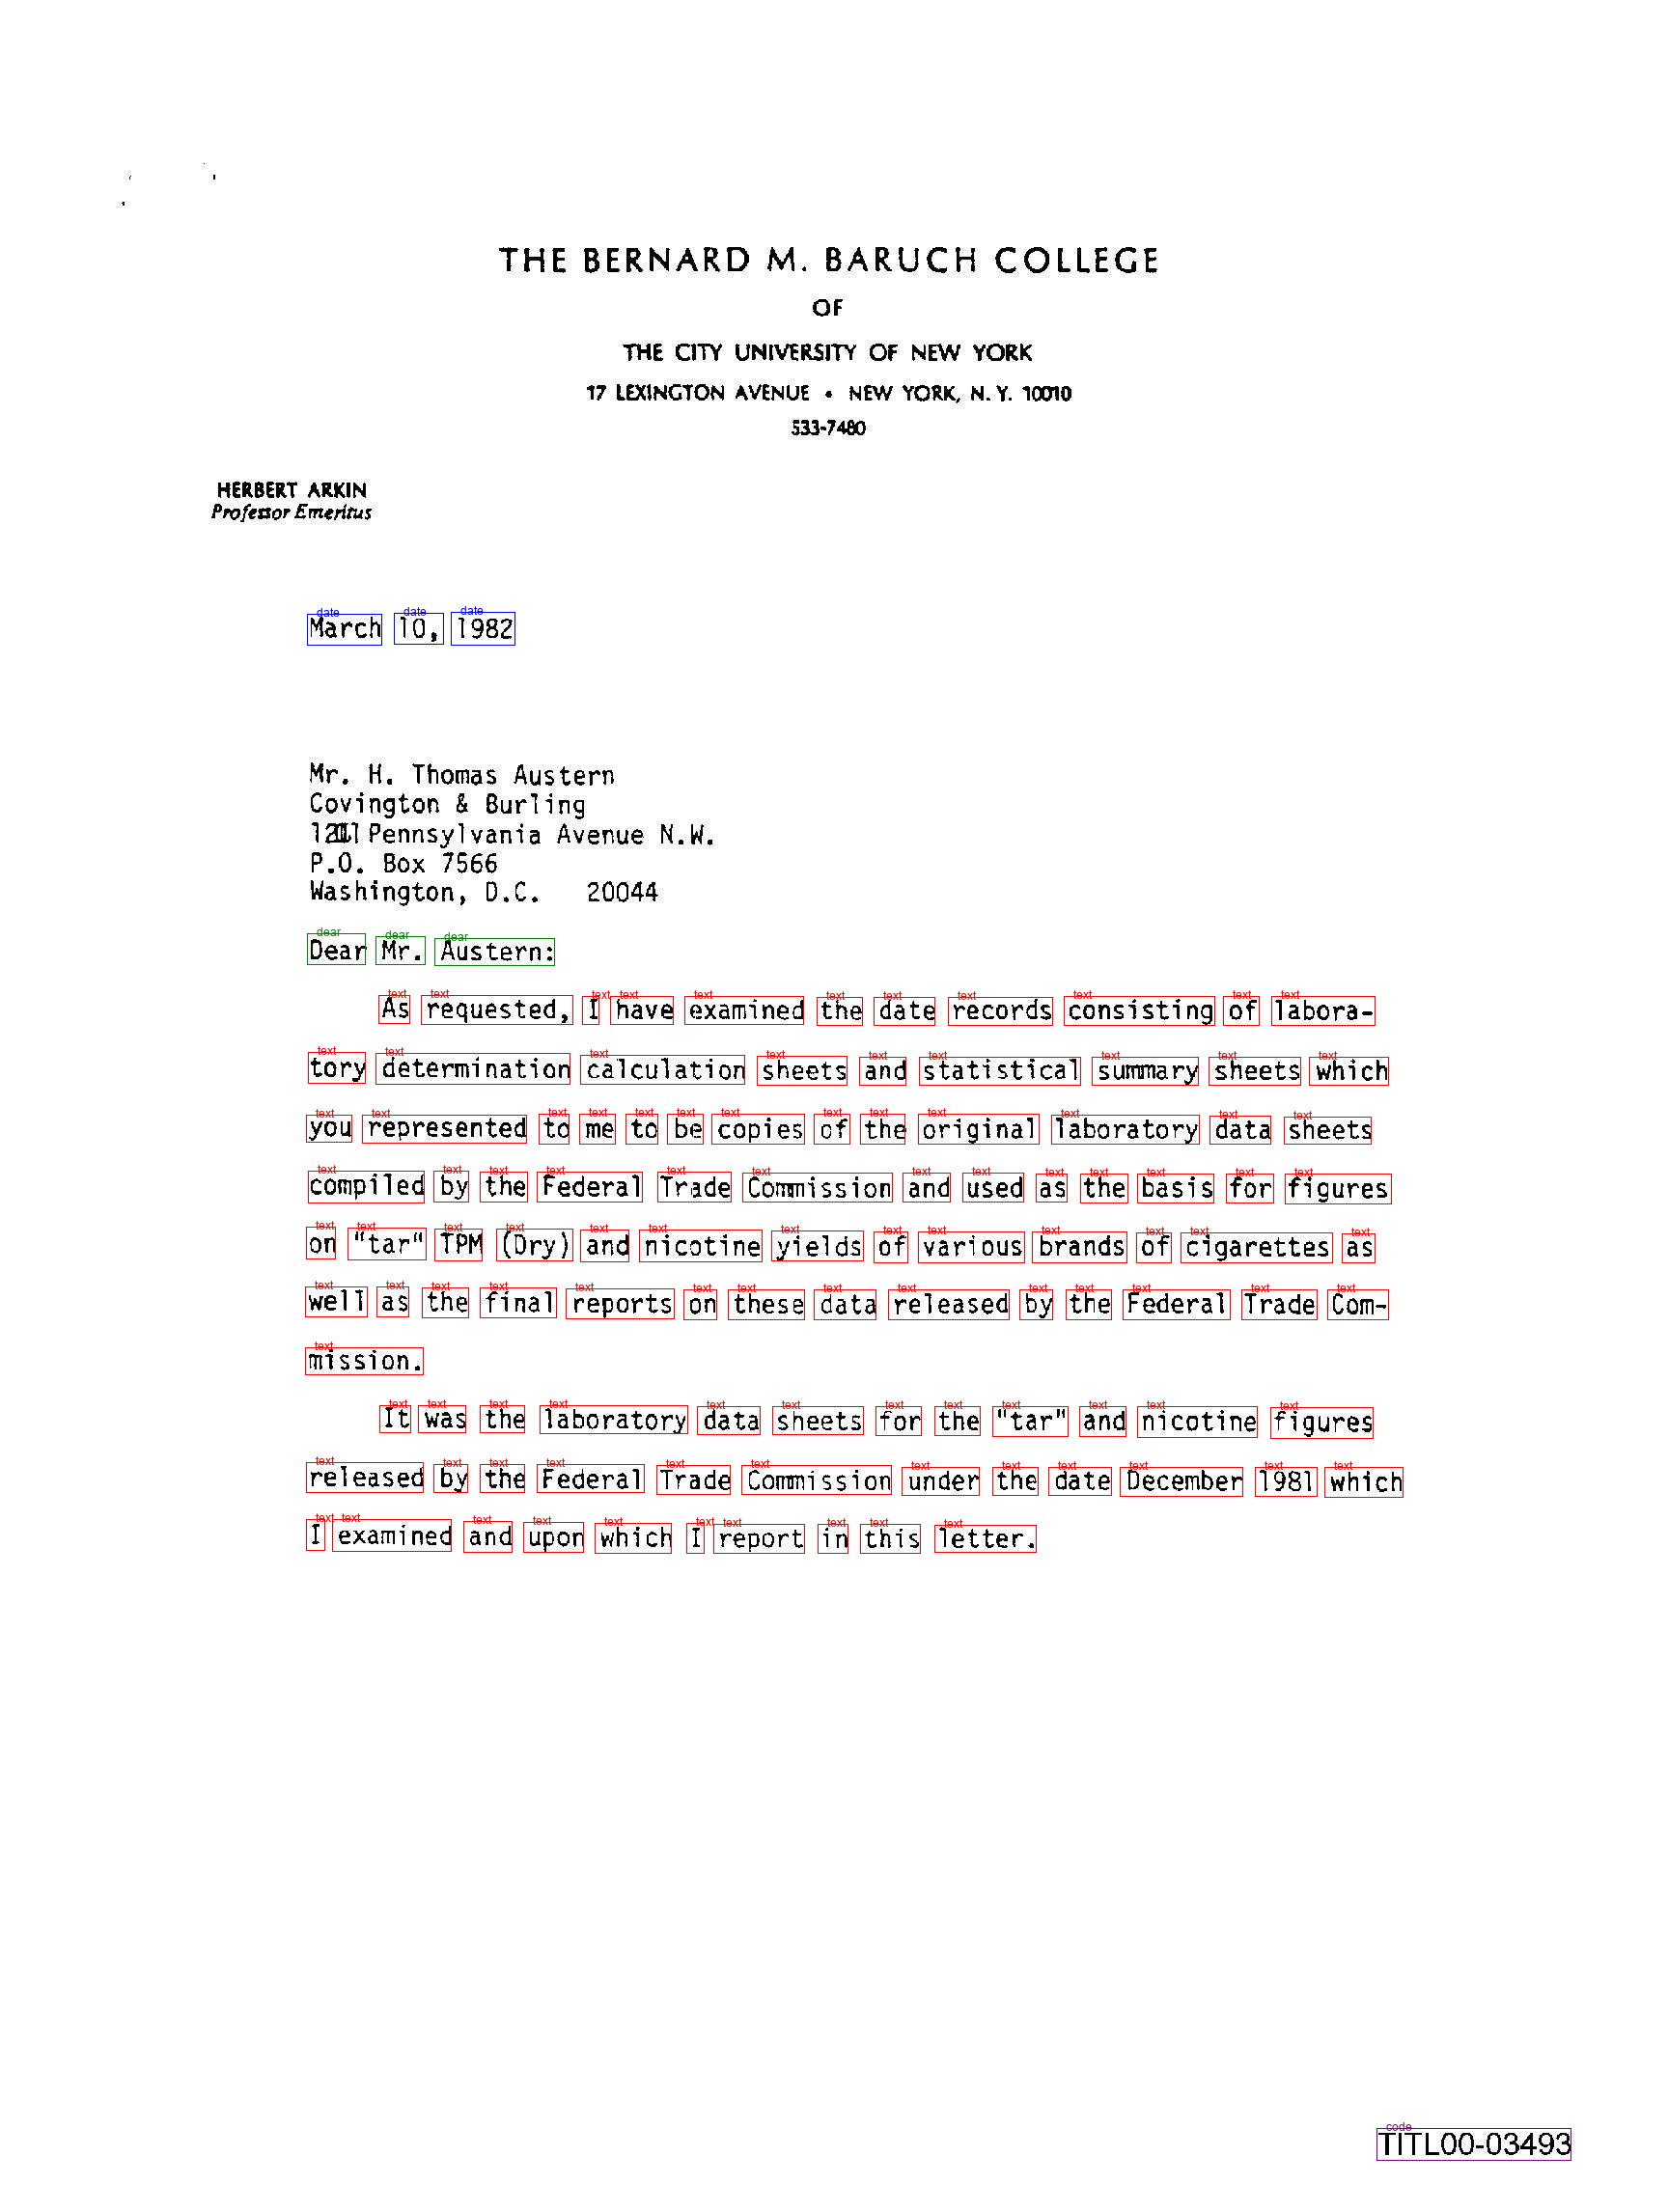

In [131]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

draw_boxes_on_img(example['ner_tags'], example['bboxes'], draw, image, True)

image

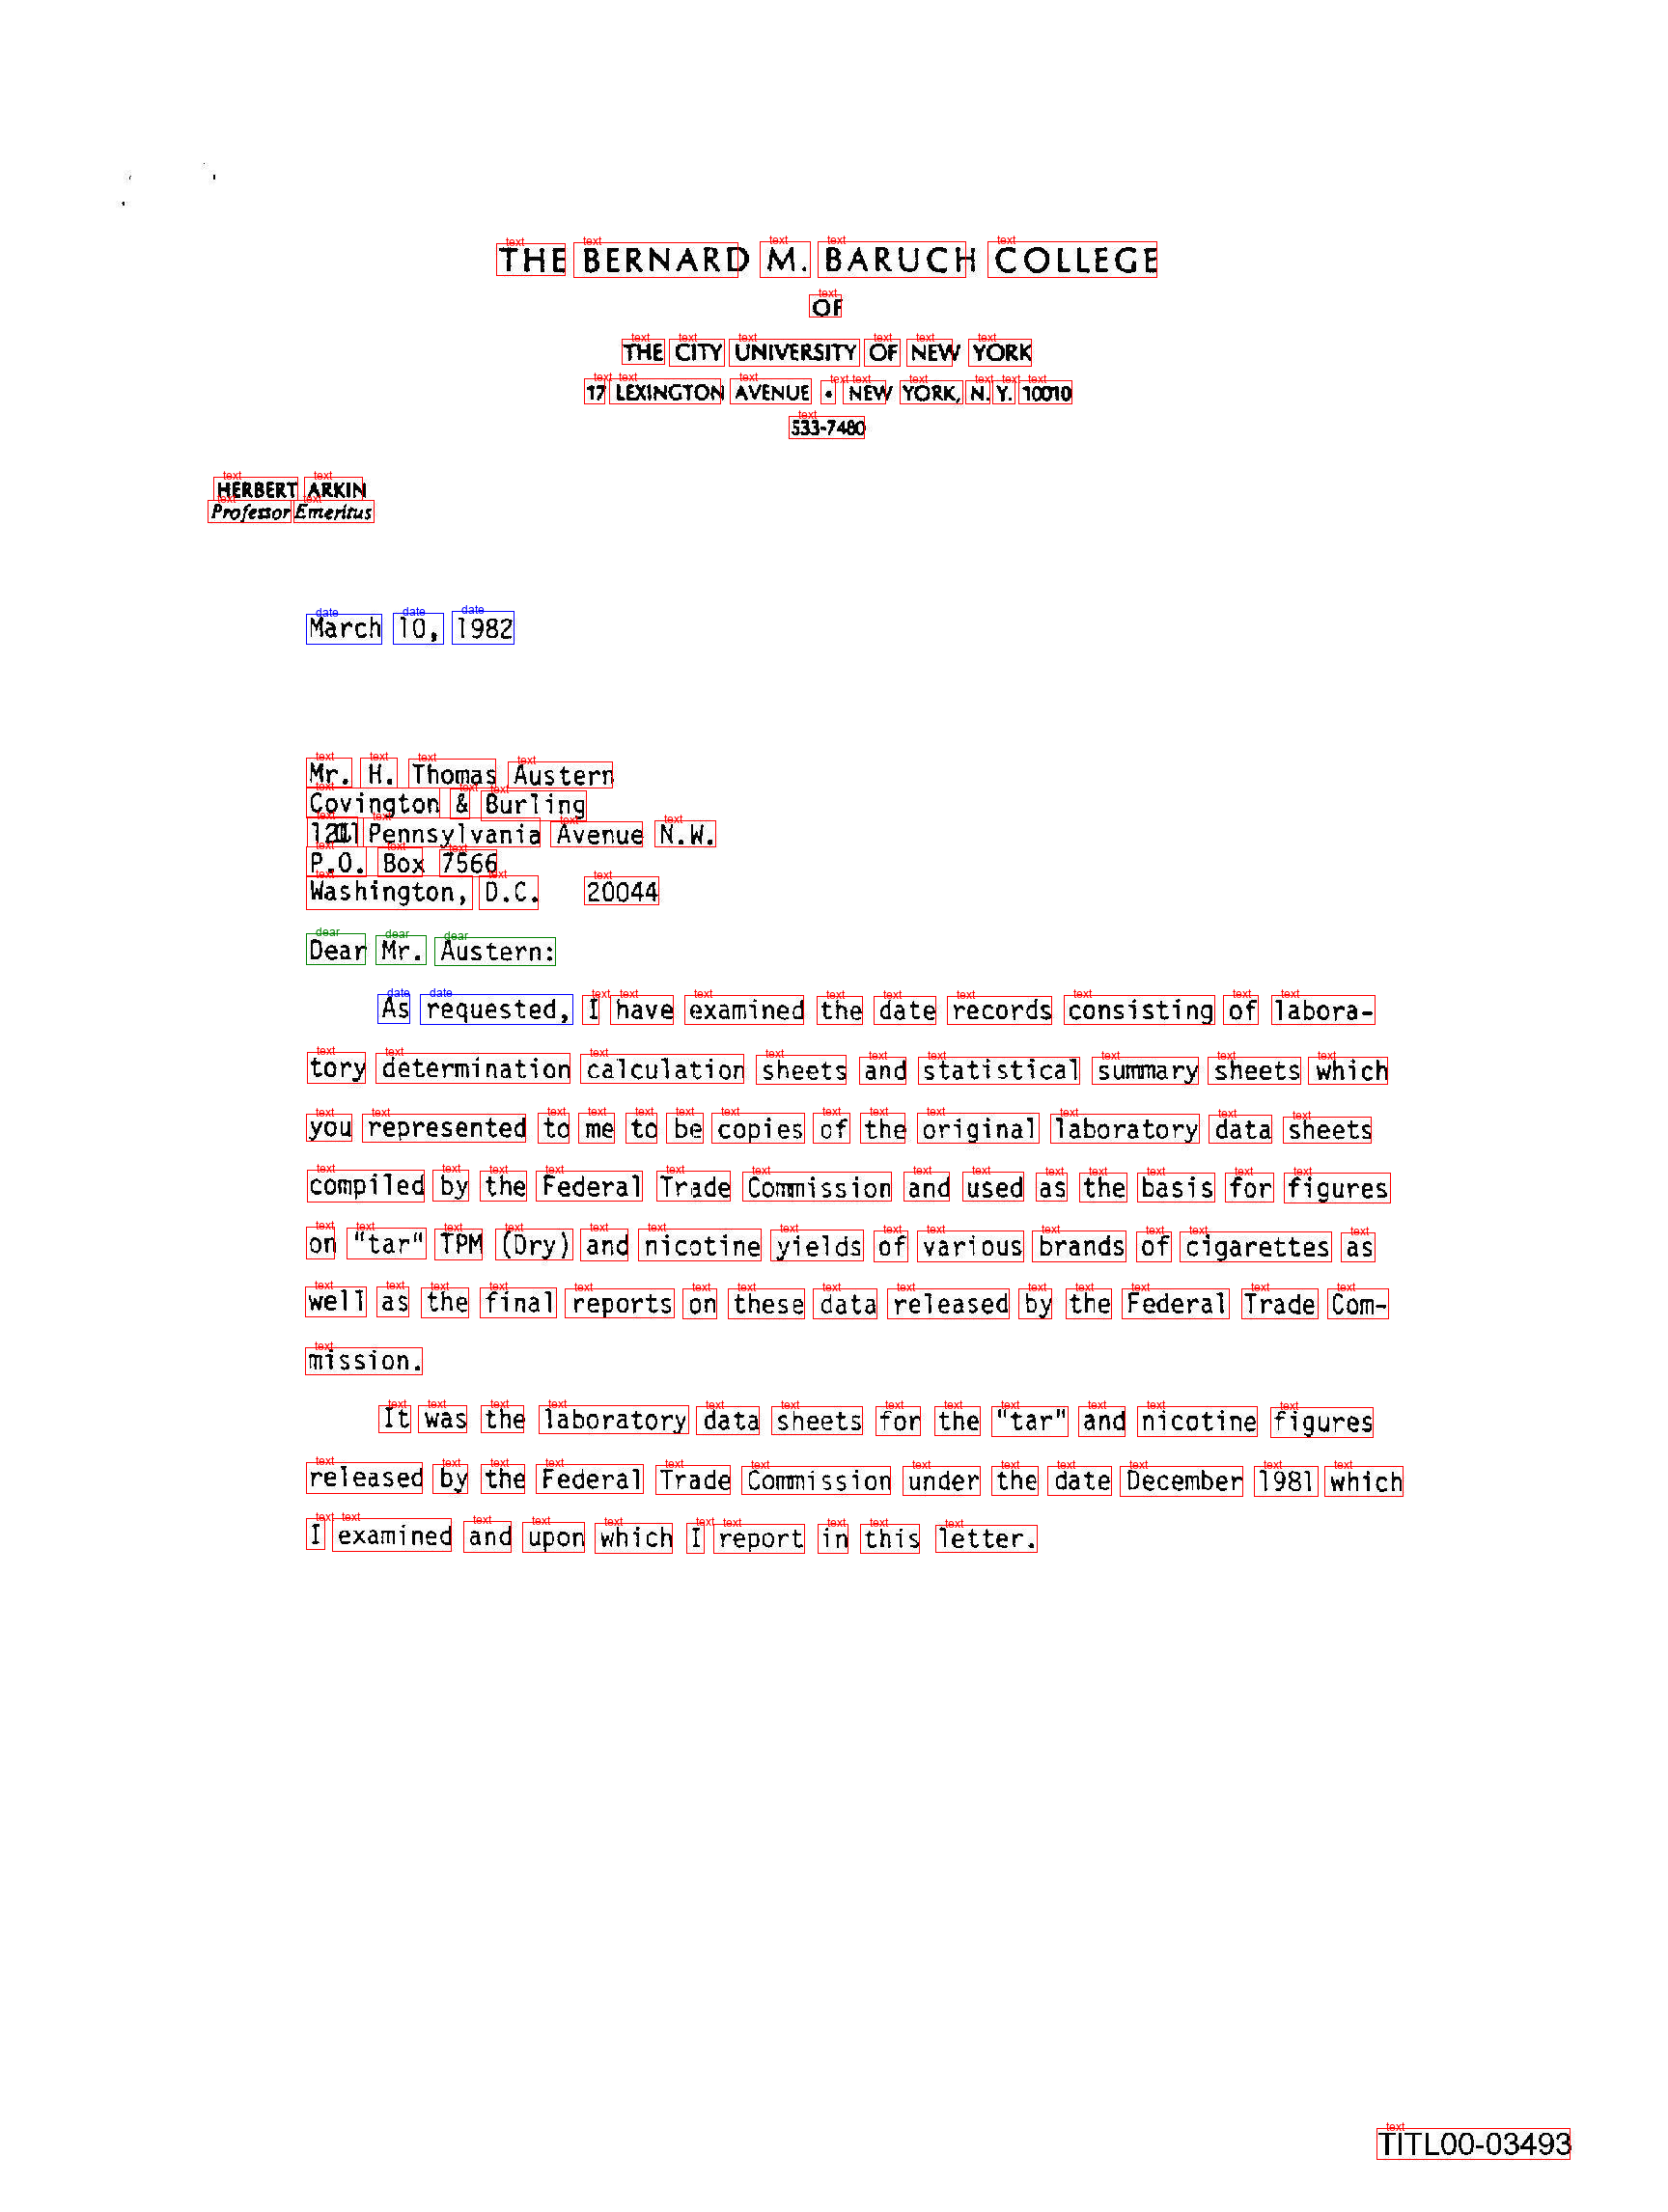

In [132]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

draw_boxes_on_img(predicted_labels[i], token_boxes, draw, image, True)

image

In [123]:
print("Dear:", " ".join([example["tokens"][i] for i, tag in enumerate(predicted_labels[i]) if tag == "I-Dear" or tag == "B-Dear" ]))
print("Date:", " ".join([example["tokens"][i] for i, tag in enumerate(predicted_labels[i]) if tag == "I-Date" or tag == "B-Date" ]))
print("text:", " ".join([example["tokens"][i] for i, tag in enumerate(predicted_labels[i]) if tag == "I-text" or tag == "B-text" ]))
print("CODE:", " ".join([example["tokens"][i] for i, tag in enumerate(predicted_labels[i]) if tag == "I-code" or tag == "B-code" ]))


Dear: Dear Bob: August
Date: 23, 1982 Since we are


IndexError: list index out of range

In [106]:
print("Dear:", " ".join([example["tokens"][i] for i, tag in enumerate(example["ner_tags"]) if tag == "I-Dear" or tag == "B-Dear"]))
print("Date:", " ".join([example["tokens"][i] for i, tag in enumerate(example["ner_tags"]) if tag == "I-Date" or tag == "B-Date"]))
print("text:", " ".join([example["tokens"][i] for i, tag in enumerate(example["ner_tags"]) if tag == "I-text" or tag == "B-text"]))
print("CODE:", " ".join([example["tokens"][i] for i, tag in enumerate(example["ner_tags"]) if tag == "I-code" or tag == "B-code" ]))


Dear: To: Hopkins Hadel, Linda L.
Date: July 20, 2001
text: FYI ... I did call him w/ the update as well per our discussion- Eric Ostern, Manager, Youth Smoking Prevention Programs
CODE: 2085121166
